<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/vigneshk01/Gesture_Recognition_Case_Study/blob/master/Neural_Nets_Project_Starter_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://www.kaggle.com/code/vigneshk01/neural-nets-project-starter-code/edit"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [1]:
# Hyperparameters to tune
hp_epoch = 50 # 10, 30, 75
hp_lr=0.01
hp_reducelr = 0.8
hp_batch_size = 50
hp_x = hp_img_cnt = 25
hp_y = hp_z = 120
hp_loss = 'categorical_crossentropy' 
hp_metrics = ['categorical_accuracy']

# Environment Setup

In [2]:
# set env to 1 for direct download from gdrive, # 2 for mounting google drive, 3 for kaggle
env = 0 
# env = int(input("Enter environment: "))

# !pip install mlflow > _
# import mlflow
# mlflow.tensorflow.autolog()

import time
start_time = time.time()

if env == 1: ## Direct file download from drive
    !gdown '1FoNRK7V0lLWf2ThyAq3TYU3kGakPBnn4' #download data file from gdrive
    !unzip Project_data.zip > tmp #unzip the file,  "A" when prompted
    
elif env == 2: ## Mount google drive Instead
    from google.colab import drive, files
    drive.mount('/content/drive')
    drive_base = '/content/drive/MyDrive/Colab_Notebooks/projects/gesture_recognition' #project root dir

    !cp -r -v {drive_base}/Project_data.zip /content
    !cd /content/
    !unzip Project_data.zip > extraction_log_dump #unzip the file,  "A" when prompted
    print('mounted and unpacked')
    !ls -la /content/
    
elif env == 3:
    # !cp -r /kaggle/input/gesture-recogniton/Project_data/Project_data/ /kaggle/working/
    # data_path = '/kaggle/input/gesture-recogniton'
    # data_path = '/kaggle/input/gesture-recogniton/Project_data'
    
    data_path = '/kaggle/input/Project_data'
    print('files copied')
    !ls -la /kaggle/input/Project_data
    
else:
    print("other env")

files copied
total 0
drwxr-xr-x 3 nobody nogroup 0 Feb  5 05:05 .
drwxr-xr-x 3 nobody nogroup 0 Feb  5 05:05 ..
drwxr-xr-x 4 nobody nogroup 0 Feb  5 05:05 Project_data


# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
import os
import cv2
import shutil
import glob 

import datetime
from re import L, match

import numpy as np
import random as rn
import matplotlib.pyplot as plt

from distutils.file_util import write_file
import warnings
warnings.filterwarnings('ignore')

from skimage.io import imread
from skimage.transform import resize
from skimage.morphology import dilation

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Conv3D, Dense  
from tensorflow.keras.layers import Dropout, Flatten, GRU, Input, MaxPooling3D
from tensorflow.keras.layers import TimeDistributed, LeakyReLU, SpatialDropout3D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PolynomialDecay 

print(keras.__version__) # '3.8.0'
print(tf.__version__) # '2.17.0'

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

3.5.0
2.17.1
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
rn.seed(30) #
tf.random.set_seed(30)
keras.utils.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
if env ==3:
    train_doc = np.random.permutation(open(data_path + '/Project_data/train.csv').readlines())
    val_doc = np.random.permutation(open(data_path + '/Project_data/val.csv').readlines())
else:
    train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
    val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = hp_batch_size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def crop_image(img):  # refer CV documentation, # this cropping approach tries to generate a grayscale image from original image and then tries to find contours, From the contours, it tries to select the contour that has maximum area, and tries to crop it
    img2cv = img.astype(np.uint8)
    img_rgb = cv2.cvtColor(img2cv, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    
    _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours_mat, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # img_sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
    # img_canny = cv2.Canny(img,100,200)
    # img_guss = cv2.GaussianBlur(binary_img,(5,5),0)
    
    # kernel1 = np.ones((3, 3), np.uint8)
    # img_dil = dilation(binary_img, kernel1)
    # img_ero = cv2.erode(binary_img, kernel1, iterations = 1)
    # img_ope = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel1)
    # img_clo = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel1)


    hulls = []
    for i in range(len(contours_mat)):
        hulls.append(cv2.convexHull(contours_mat[i]))
        
    if len(hulls) > 0:
        contours_sorted = sorted(hulls, key=lambda x: cv2.contourArea(x), reverse=True)
        selected_contour = contours_sorted[0]
        
        x, y, w, h = cv2.boundingRect(selected_contour)
        cropped_image = img[y:y+h, x:x+w]
        return cropped_image
    else:
        return img

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = rn.sample(range(0,30), hp_img_cnt)  #creates a list of image numbers to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        remaining_sequences = len(folder_list)%batch_size
        x = len(img_idx)
        z , y = hp_z, hp_y

        for batch in range(num_batches): # iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx, item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images
                    image = image[25:-25,25:-25]
                    # image = crop_image(image)
                    
                    #resize the image to 120x120
                    image = resize(image, (y,z))
                    normalized_img = image/255

                    batch_data[folder,idx,:,:,0] = normalized_img[:,:,0] #normalize and feed in the image
                    batch_data[folder,idx,:,:,1] = normalized_img[:,:,1] #normalize and feed in the image
                    batch_data[folder,idx,:,:,2] = normalized_img[:,:,2] #normalize and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # yields the batch_data and the batch_labels 


        # code for the remaining data points which are left after full batches
        if remaining_sequences > 0:
            batch = num_batches
            batch_data = np.zeros((remaining_sequences,x,y,z,3)) # x is the number of images for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_sequences,5)) # batch_labels is the one hot representation of the output
                
            for folder in range(remaining_sequences):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx, item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    image = image[25:-25,25:-25]
                    # image = crop_image(image)
                    
                    #resize the image to 120x120
                    image = resize(image, (y,z)) 
                    normalized_img = image/255

                    batch_data[folder,idx,:,:,0] = normalized_img[:,:,0] #normalize and feed in the image
                    batch_data[folder,idx,:,:,1] = normalized_img[:,:,1] #normalize and feed in the image
                    batch_data[folder,idx,:,:,2] = normalized_img[:,:,2] #normalize and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # yields the batch_data and the batch_labels 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = hp_epoch # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
#### MobileNetV2 is a highly efficient pre-trained model designed for mobile and embedded devices
base_model = MobileNetV2(include_top=False, weights="imagenet")

# To disable training the layers in base model
# for layer in base_model.layers[:-20]:
#     layer.trainable = False
    
for layer in base_model.layers[:-15]:
    layer.trainable = False
    
# for layer in base_model.layers[:-6]:
#     layer.trainable = False

# for layer in base_model.layers[:-4]:
#     layer.trainable = False

# for layer in base_model.layers[:3]:
#     layer.trainable = False

# for layer in base_model.layers:
#     layer.trainable = False

#Sequential groups a linear stack of layers into a Model.
model = Sequential()
model.add(Input(shape=(hp_x, hp_y, hp_z, 3)))

# TimeDistributed wrapper allows to apply a layer to every temporal slice of an input
model.add(TimeDistributed(base_model))
model.add(TimeDistributed(Flatten()))

# Gated Recurrent Unit
model.add(GRU(64, activation="elu", return_sequences=False))
# model.add(GRU(32, activation="elu", return_sequences=False))
# model.add(GRU(512, activation="elu", return_sequences=False))

model.add(Dropout(0.5))
# model.add(Dropout(0.5))

# Densely connected layer
model.add(Dense(units=32, activation="elu"))
# model.add(Dense(units=512, activation="elu"))
model.add(Dropout(0.5))# Dropout randomly sets input units to 0
 
model.add(Dense(5, activation='softmax'))
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 25, 3, 3, 1280)      │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 25, 11520)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │       2,224,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,484,741 (17.11 MB)

 Trainable params: 3,266,757 (12.46 MB)

 Non-trainable params: 1,217,984 (4.65 MB)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
# lr_schedule = ExponentialDecay(hp_lr, num_train_sequences//batch_size, 0.09, staircase=False, name="ExponentialDecay") # exponential decay schedule
# lr_schedule = PolynomialDecay(hp_lr, num_train_sequences//batch_size, 0.00001, power=0.5) # polynomial decay schedule.

optimizer = optimizers.Adam(learning_rate = hp_lr) # Adam - Adaptive estimation of first-order and second-order moments
# optimizer = optimizers.SGD(learning_rate = hp_lr) # SGD - Gradient descent (with momentum) optimizer
# optimizer = optimizers.Adam(learning_rate = lr_schedule) 

#Model configuration
model.compile(optimizer=optimizer, loss=hp_loss, metrics=hp_metrics)

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
if env ==3:
    train_path = data_path+'/Project_data/train'
    val_path = data_path+'/Project_data/val'

# Instantiate the generators
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint - To save the model after every epoch
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau - Reduce learning rate when there is no change in val_loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=hp_reducelr, patience=5, min_lr=0.0001) # write the REducelronplateau code here

# EarlyStopping - Stop training when val_loss has stopped decreasing
early_stop = EarlyStopping(monitor="val_categorical_accuracy", patience=10,, mode=max, verbose=1, start_from_epoch=30)

# CSVLogger - log epoch results in a csv
csv_logger = CSVLogger('training.csv', separator=",", append=True)

callbacks_list = [checkpoint, reduce_lr, early_stop, csv_logger]


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
# Train the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps,
          class_weight=None, initial_epoch=0)

Source path =  /kaggle/input/Project_data/Project_data/train ; batch size = 50
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - categorical_accuracy: 0.2282 - loss: 6.9623 Source path =  /kaggle/input/Project_data/Project_data/val ; batch size = 50

Epoch 1: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_init_2025-02-0820_01_02.578225/model-00001-5.24720-0.22775-1.65920-0.16000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 435s 22s/step - categorical_accuracy: 0.2281 - loss: 6.8480 - val_categorical_accuracy: 0.1600 - val_loss: 1.6592 - learning_rate: 0.0100
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2520 - loss: 1.9118
Epoch 2: val_categorical_accuracy did not improve from 0.16000
14/14 ━━━━━━━━━━━━━━━━━━━━ 124s 9s/step - categorical_accuracy: 0.2516 - loss: 1.9126 - val_categorical_accuracy: 0.1600 - val_loss: 1.6884 - learning_rate: 0.0100
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2509 - loss: 1.76

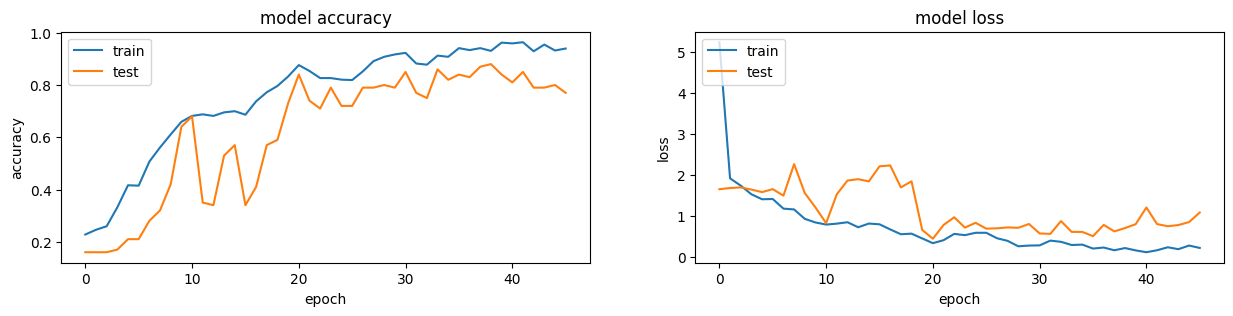

In [15]:
# Plot the accuracy graph and save to a file
hist = model.history.history

fig, axs = plt.subplots(1,2, figsize=(15,3))
axs[0].plot(hist['categorical_accuracy'])
axs[0].plot(hist['val_categorical_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper left')

axs[1].plot(hist['loss'])
axs[1].plot(hist['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper left')

fig.savefig(model_name+"graph.png");
# plt.show();

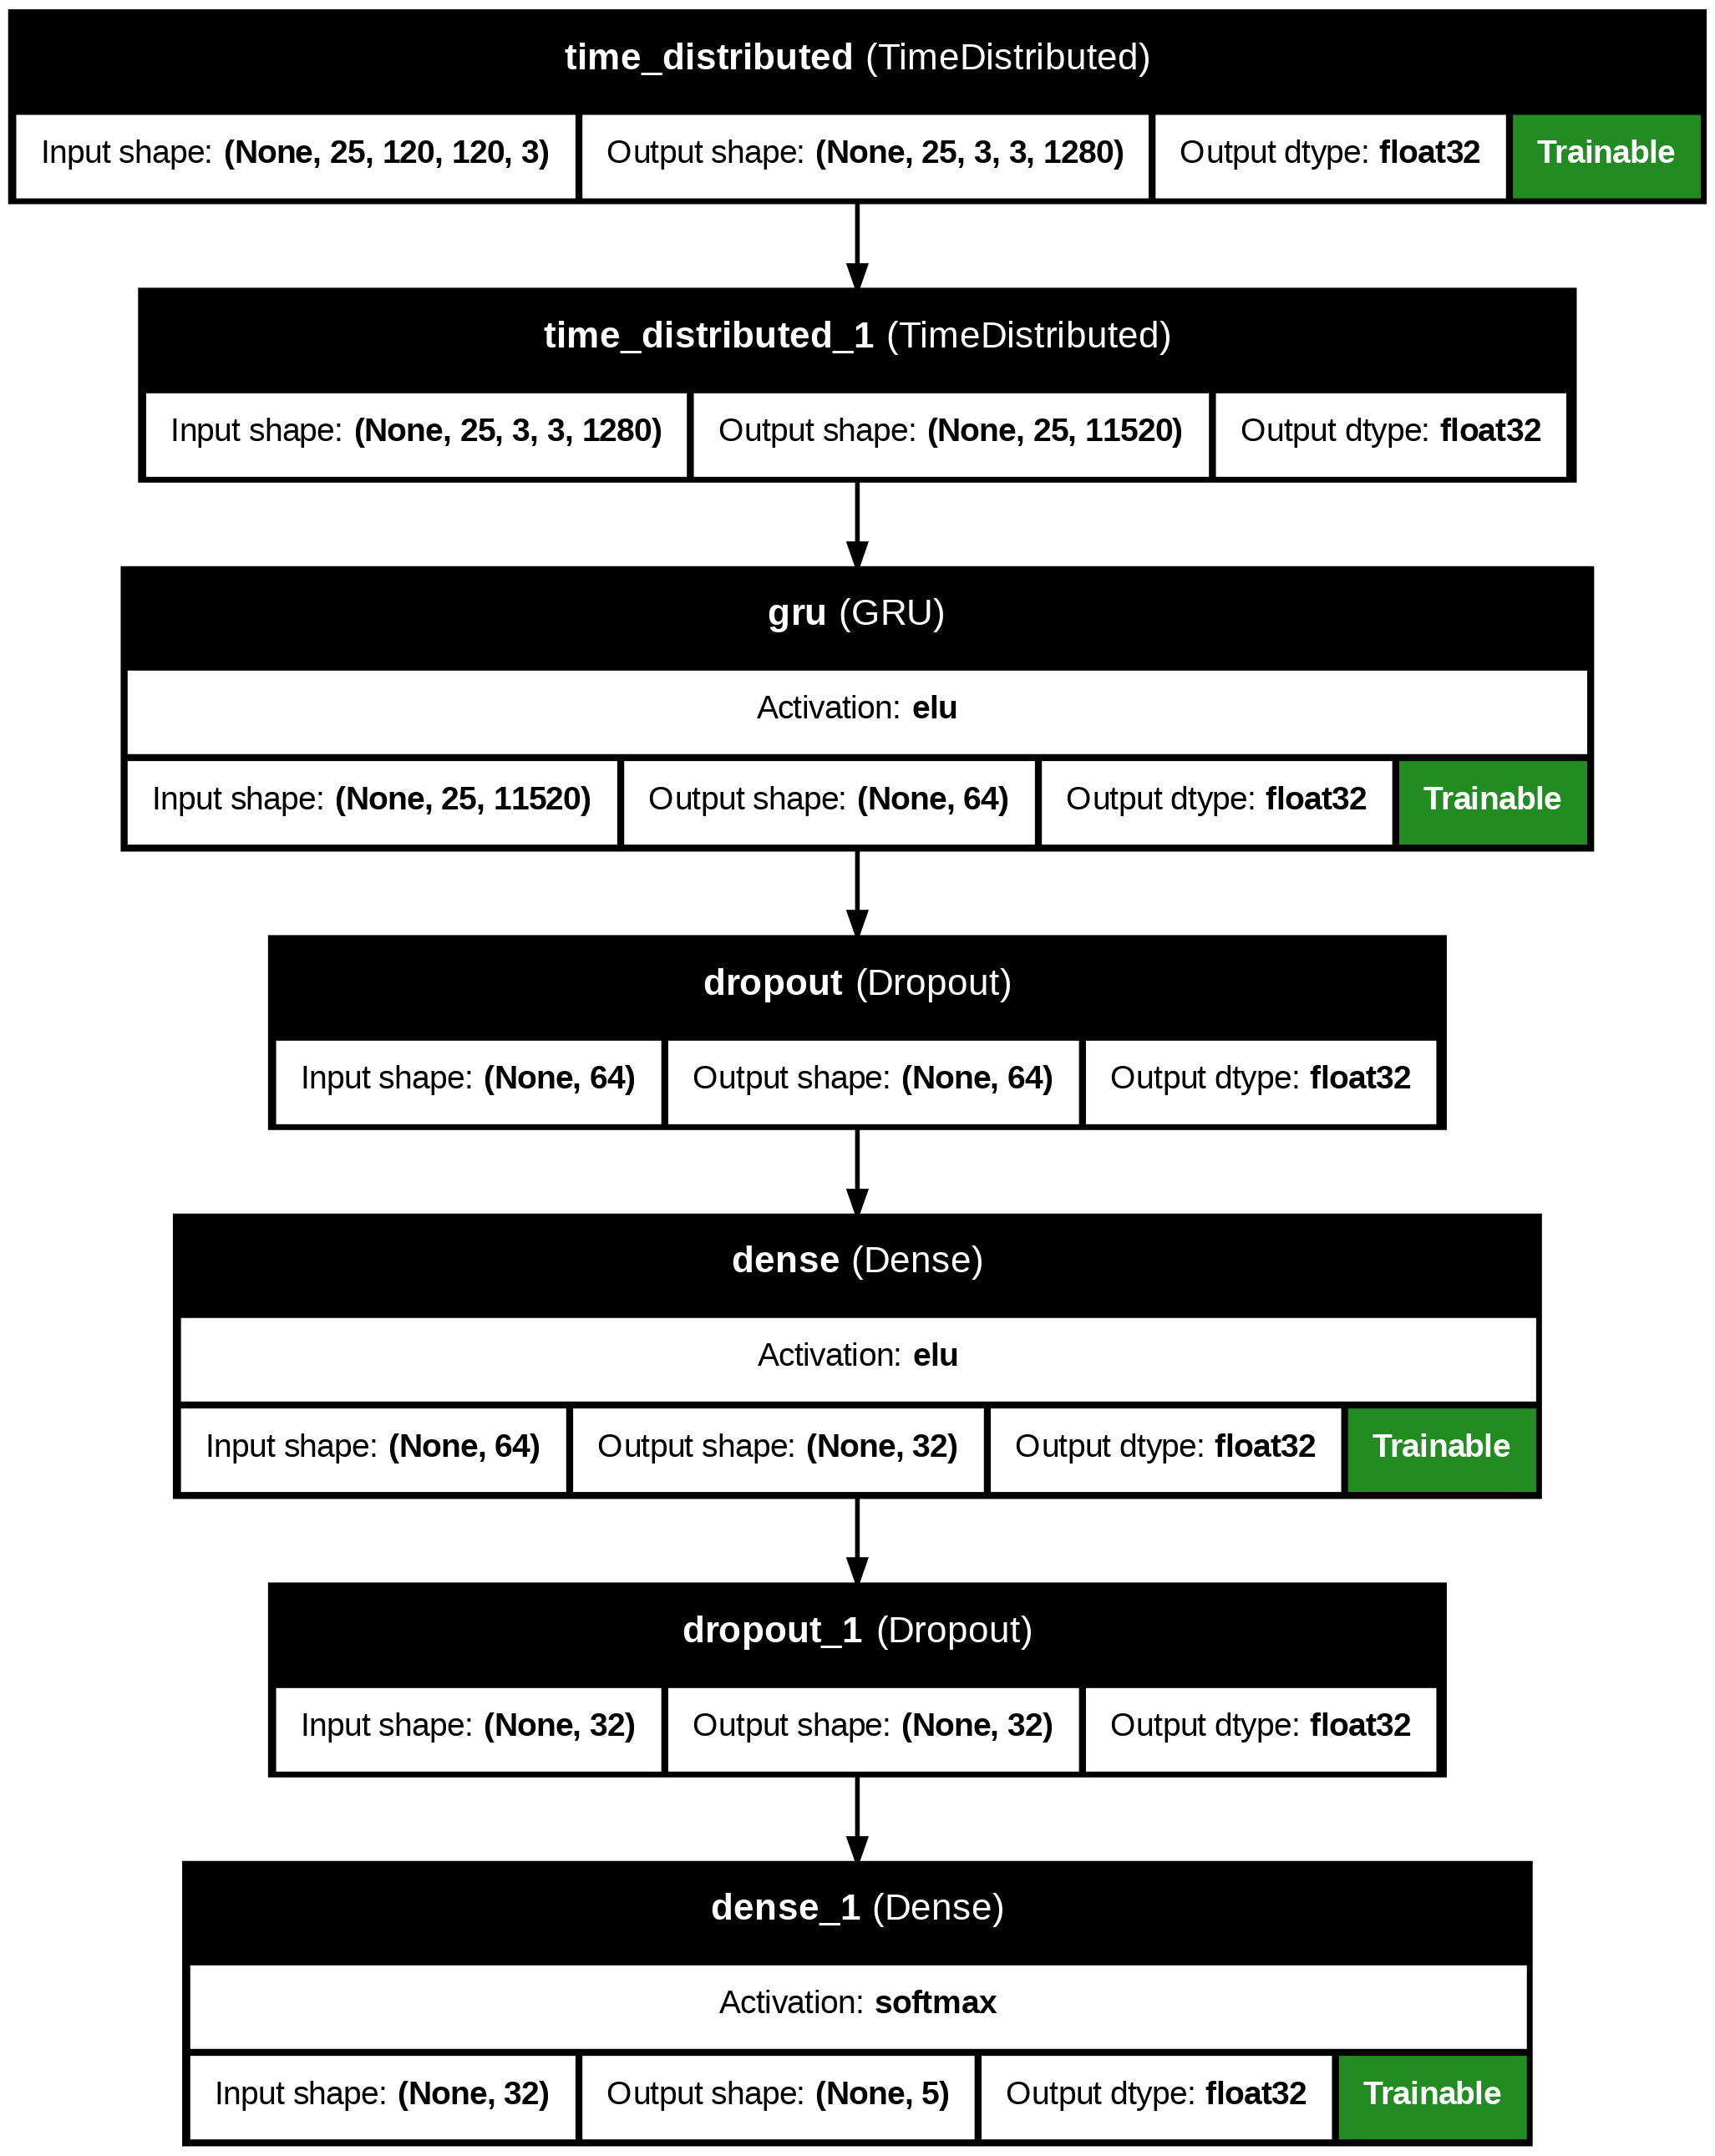

In [16]:
#saves the model summary to a file
with open(model_name+'model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write(str([hp_epoch, hp_batch_size, hp_img_cnt, hp_lr, hp_reducelr, hp_y, hp_z]))
    
#saves the model plot to a file        
keras.utils.plot_model(
    model, to_file=model_name+"model.png", show_shapes=True, show_dtype=True, show_layer_names=True,
    rankdir="TB", expand_nested=True, dpi=200, show_layer_activations=True, show_trainable=True)

In [17]:
#Post Processing Steps
if env == 1: # direct download from colab
    files.download('model.keras')
  
elif env == 2: 
    # do not forget to move the model to the drive output folder
    shutil.move(model_name, drive_base+'/outputs')
    
elif env == 3: #kaggle
    if not os.path.exists('outputs'):
        os.mkdir('outputs')
   
    if os.path.exists('outputs'):
        files_paths = glob.glob('model_init*', dir_fd='./', recursive=True)
        for path in files_paths:
            shutil.move(path , 'outputs')
            
        pattern = '**/*.keras'
        files_paths = glob.glob(pattern, root_dir='outputs/', recursive=True)
    
        with open('outputs/'+model_name+'model_summary.txt', 'a') as f:
            f.write(str(files_paths))
    
        match_op = [match(r'model_init_[-_.\d]+/model[-\d\.]*(\d{5}).keras', path) for path in files_paths]
    
        accuracy_list = [i.group(1) for i in match_op]
        accuracy_list.sort(reverse=True)

        for item in accuracy_list[4:]:
            for path in files_paths:
                if item in path:
                    os.remove('outputs/'+path)
                
        #At the end, zip the output folder
        # shutil.make_archive('model_output_latest', 'zip', '/kaggle/working/outputs/')    
        # !rm -rf outputs/ 
    
else:
    shutil.move(model_name , 'outputs')

end_time = time.time()
total_time = end_time - start_time 
print(f'{total_time}')

6556.190421819687
